# Total 0-75

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('W:\COVID19\std_inz0_75.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_0to75']
X0 = df.loc[:, ~df.columns.isin(['std_inz_0to75', 'eastwest'])]
f_names = list(X0.columns)
print("Number of features: ", len(X0.columns))

Number of features:  162


# Feature Correlation

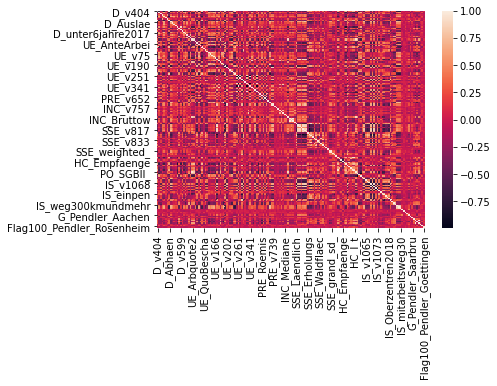

In [4]:
corr = X0.corr()
sns.heatmap(corr)

In [5]:
pairs = []

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.8:
            pairs.append(corr.columns[[i,j]][0])
            pairs.append(corr.columns[[i,j]][1])
            print(corr.columns[[i,j]],corr.iloc[i,j])
            

Index(['D_v404', 'D_v424'], dtype='object') -0.8180497795631676
Index(['D_v404', 'D_Abhaen'], dtype='object') 0.9524120276596159
Index(['D_v404', 'UE_AnteBesch'], dtype='object') 0.8008403114754826
Index(['D_v404', 'UE_v231'], dtype='object') 0.8196861944797873
Index(['D_Lebens', 'D_v599'], dtype='object') 0.9204456724863157
Index(['D_Lebens', 'HC_Vorzeitig'], dtype='object') -0.8535707254811613
Index(['UE_Arbquote2', 'UE_ArbquoteJ'], dtype='object') 0.9119272462198496
Index(['UE_Arbquote2', 'INC_Schuldn'], dtype='object') 0.8521879889184761
Index(['UE_Arbquote2', 'PO_SGBII_'], dtype='object') 0.9463415538519439
Index(['UE_ArbquoteJ', 'PO_SGBII_'], dtype='object') 0.8310490758054112
Index(['UE_AntreBesc', 'UE_AnteBesch'], dtype='object') -0.8073819685836331
Index(['UE_BesePrima', 'UE_v305'], dtype='object') 0.8333318048923836
Index(['UE_Erwerb', 'SSE_Einwohner'], dtype='object') 0.8980642650031009
Index(['UE_Erwerb', 'SSE_v967'], dtype='object') 0.954018824286417
Index(['UE_Erwerb', 'S

In [6]:
len(pairs)
len(set(pairs))

68

In [7]:
#sns.heatmap(X[set(pairs)].corr())

In [8]:
a=["PRE_v652","SSE_AnteilErh","SSE_AnteilFre","SSE_AnteilFre","SSE_Freiflaec","SSE_Freiflaec","SSE_Laendlich","SSE_Laendlich","SSE_Siedlungs","SSE_Siedlungs","SSE_Siedlungs","SSE_v817","SSE_v817","SSE_v817","SSE_v817","SSE_v817","SSE_v967","SSE_v967","SSE_v967","SSE_v967","SSE_weighted_","UE_AntreBesc","UE_Arbquote2","UE_Arbquote2","UE_Arbquote2","UE_ArbquoteJ","UE_BesePrima","UE_v323","UE_v323","UE_v324","UE_v341","HC_Vorzeitig","D_v599","UE_AnteBesch","D_v424","UE_v231","D_Abhaen","HC_I_t","HC_II_t","HC_I_t","HC_Pflegehe","IS_mitarbeitsweg30","IS_mitarbeitsweg15","IS_v1071","IS_v1071","IS_v1073","PO_Hausha","PRE_v739","IS_v1069","IS_v1071","SSE_AnteilWas","SSE_AnteilErh","SSE_Siedlungs","SSE_AnteilFre","SSE_v817","SSE_v967","IS_v1070","SSE_Waldflaec","IS_v1071","SSE_Freiflaec","IS_v1069","SSE_AnteilFre","IS_v1071","IS_v1069","IS_v1071","SSE_Siedlungs","SSE_AnteilErh","SSE_AnteilFre","SSE_AnteilErh","SSE_Siedlungs","SSE_AnteilFre","SSE_v817","SSE_grand_sd_","INC_Schuldn","UE_ArbquoteJ","IS_auspen","IS_endlersaldo2017","HC_aerztever","SSE_AnteilErh","SSE_Siedlungs","SSE_AnteilFre","SSE_Einwohner","SSE_v817","SSE_v967","UE_v342","PRE_v727","PRE_v739","PRE_v733","UE_v381","UE_v341","UE_v323","UE_v261","UE_v381","UE_v323","UE_v341","UE_v381","UE_v341","UE_v381"]
print(set(a),"\n\n",len(set(a)),"features droped")

{'UE_v261', 'UE_v341', 'IS_v1071', 'SSE_Laendlich', 'HC_Vorzeitig', 'IS_v1073', 'HC_Pflegehe', 'PRE_v739', 'UE_v323', 'SSE_grand_sd_', 'HC_I_t', 'IS_mitarbeitsweg15', 'IS_endlersaldo2017', 'SSE_AnteilErh', 'HC_aerztever', 'SSE_v967', 'D_v424', 'SSE_v817', 'UE_v324', 'D_v599', 'IS_auspen', 'UE_v381', 'UE_AntreBesc', 'UE_ArbquoteJ', 'PRE_v733', 'UE_Arbquote2', 'SSE_Siedlungs', 'IS_v1070', 'SSE_AnteilFre', 'UE_v231', 'HC_II_t', 'UE_BesePrima', 'INC_Schuldn', 'PO_Hausha', 'SSE_Einwohner', 'IS_mitarbeitsweg30', 'PRE_v727', 'D_Abhaen', 'SSE_weighted_', 'IS_v1069', 'SSE_Freiflaec', 'SSE_Waldflaec', 'PRE_v652', 'SSE_AnteilWas', 'UE_AnteBesch', 'UE_v342'} 

 46 features droped


In [9]:
X = X0.drop(columns=['UE_v324', 'SSE_Laendlich', 'UE_AnteBesch', 'IS_endlersaldo2017', 'UE_ArbquoteJ', 'PRE_v727', 'IS_v1069', 'SSE_Siedlungs', 'D_v424', 'D_v599', 'HC_II_t', 'SSE_Waldflaec', 'HC_Pflegehe', 'IS_v1073', 'SSE_weighted_', 'SSE_AnteilFre', 'HC_Vorzeitig', 'HC_I_t', 'PO_Hausha', 'UE_AntreBesc', 'IS_mitarbeitsweg30', 'SSE_grand_sd_', 'D_Abhaen', 'UE_v261', 'SSE_v967', 'INC_Schuldn', 'PRE_v739', 'UE_Arbquote2', 'SSE_AnteilWas', 'PRE_v652', 'IS_auspen', 'UE_v323', 'SSE_Freiflaec', 'UE_v381', 'UE_v231', 'IS_v1070', 'SSE_AnteilErh', 'UE_v342', 'HC_aerztever', 'SSE_Einwohner', 'UE_v341', 'IS_mitarbeitsweg15', 'SSE_v817', 'IS_v1071', 'PRE_v733', 'UE_BesePrima'])
print("New number of features: ", len(X.columns))

New number of features:  116


# First CatBoost Model with 162 features

In [10]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9993770429823065


In [11]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  0.35963800261424944


# SHAP VAlues

In [12]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

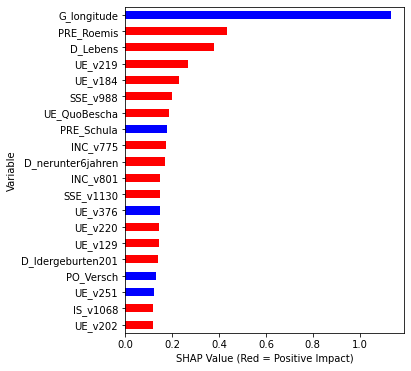

In [13]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

In [14]:
#shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [15]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [16]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9976663880669481


In [17]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  0.6960666946176474


# Compare top 10 features of both Models

In [18]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['G_longitude', 'PRE_Roemis', 'D_Lebens', 'UE_v219', 'UE_v184', 'SSE_v988', 'UE_QuoBescha', 'PRE_Schula', 'INC_v775', 'D_nerunter6jahren'] 

 10 most important features from model with top20 features: 
 ['G_longitude', 'PRE_Roemis', 'D_Lebens', 'UE_v219', 'UE_v376', 'SSE_v988', 'D_ldergeburten201', 'UE_QuoBescha', 'INC_v801', 'UE_v251']


In [19]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

G_longitude
PRE_Roemis
D_Lebens
UE_v219
SSE_v988
UE_QuoBescha


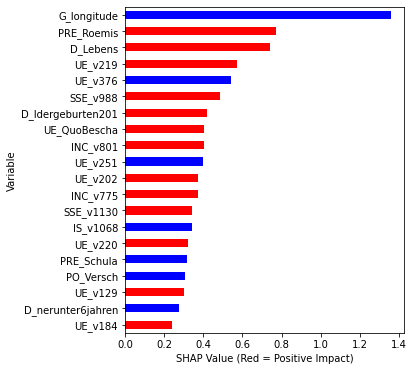

In [20]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

In [21]:
#shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [22]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [23]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9985515925578907
Mean R2 of linReg_modesl with top20 features:  0.22677999400195997
Mean RMSE of CatBoost_models on test sets with top20 features:  9.715448949866296
Mean R2 of CatBoost_models on test sets with top20 features: -0.6262710052124241


# descriptives of top20 features

In [24]:
X[top20feature].describe()

,G_longitude,PRE_Roemis,D_Lebens,UE_v219,UE_v184,SSE_v988,UE_QuoBescha,PRE_Schula,INC_v775,D_nerunter6jahren,INC_v801,SSE_v1130,UE_v376,UE_v220,UE_v129,D_ldergeburten201,PO_Versch,UE_v251,IS_v1068,UE_v202
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,9.866996,32.242809,80.655960,12.901742,2.814465,33367.324219,52.529175,6.557357,14.988533,11.580303,2846.079834,-86.781784,20.240156,34.556618,5.669324,16.510975,1682.695190,31.871574,1050.970093,11.958108
std,2.026269,24.361435,1.012629,2.768405,3.325890,30681.785156,3.597842,2.242232,4.460500,4.918641,926.153870,6.361413,4.537329,13.284163,9.243236,8.783781,1549.749390,11.464512,542.184448,5.170279
min,6.083333,1.700000,77.860001,6.100000,-7.200000,1062.000000,40.400002,2.100000,1.000000,-1.600000,28.000000,-93.599998,10.800000,4.600000,-22.299999,-9.600000,0.000000,0.000000,13.000000,4.800000
25%,8.216666,7.900000,80.010002,11.100000,0.500000,15678.000000,50.500000,4.900000,12.600000,8.300000,2706.000000,-88.199997,17.000000,26.100000,1.000000,11.700000,649.700012,24.400000,582.000000,8.500000
50%,9.766666,29.100000,80.629997,12.900000,3.100000,24587.000000,52.700001,6.300000,15.000000,11.900000,3052.000000,-87.500000,19.299999,32.000000,8.500000,17.600000,1167.900024,31.700001,1056.000000,10.300000
75%,11.416667,52.299999,81.440002,14.800000,5.100000,39522.000000,55.099998,8.000000,17.700001,14.500000,3329.000000,-86.500000,22.400000,41.400002,12.000000,21.900000,2247.600098,40.500000,1458.000000,13.700000
max,14.983334,87.800003,83.599998,21.900000,12.400000,174293.000000,60.799999,16.700001,35.599998,33.200001,4855.000000,0.000000,38.500000,101.000000,26.600000,45.500000,9908.299805,61.900002,2782.000000,33.200001


In [25]:
pd.DataFrame(Y).describe()

,std_inz_0to75
count,401.000000
mean,7.706820
std,14.427098
min,0.000000
25%,2.452555
50%,5.019764
75%,9.171128
max,259.999207


In [26]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives1.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 1')